# Training of DL models for Multi-regression of the metabolites concentrations

### Install project packages

In [4]:
%%bash
pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///data/ar1220/MscProjectNMR
  Attempting uninstall: MscProjectNMR
    Found existing installation: MscProjectNMR 0
    Uninstalling MscProjectNMR-0:
      Successfully uninstalled MscProjectNMR-0
  Running setup.py develop for MscProjectNMR


### Install required python modules

In [ ]:
%%bash
pip install -r ../requirements.txt

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

8 Physical GPUs, 8 Logical GPUs


### Import fucntions

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from numba import cuda

import joblib
import os

from tfrecords import read_tfrecords_concentrations, read_tfrecords_concentrations_single
from models import get_simple_mutli_regressor_mlp, get_regularised_bn_dropout_mutli_regressor_mlp, CheckpointCallback

In [2]:
tf.__version__

'2.4.2'

---
# I. Read the tf.Record files

## I.1 Small independent dataset (1000 spectra)

In [2]:
small_train_file_paths = ['../data/tfrecords/Concentrations_data/Small_sample/train/data_{}.tfrecord'.format(i)
                    for i in range(8)]
small_val_file_paths = ['../data/tfrecords/Concentrations_data/Small_sample/validation/data_{}.tfrecord'.format(i)
                    for i in range(2)]

small_train_dataset = read_tfrecords_concentrations(small_train_file_paths, 32)

small_val_dataset = read_tfrecords_concentrations(small_val_file_paths, 32)

## I.2 Small correlated dataset (1000 spectra)

In [5]:
small_corr_train_file_paths = ['../data/tfrecords/Concentrations_data/Small_correlated/train/data_{}.tfrecord'
                               .format(i) for i in range(8)]
small_corr_val_file_paths = ['../data/tfrecords/Concentrations_data/Small_correlated/validation/data_{}.tfrecord'
                             .format(i) for i in range(2)]

small_corr_train_dataset = read_tfrecords_concentrations(small_corr_train_file_paths, 32)

small_corr_val_dataset = read_tfrecords_concentrations(small_corr_val_file_paths, 32)


## I.3 Large independent dataset (10000 spectra)

In [6]:
large_train_file_paths = ['../data/tfrecords/Concentrations_data/Large_sample/train/data_{}.tfrecord'.format(i) 
                        for i in range(32)]
large_val_file_paths = ['../data/tfrecords/Concentrations_data/Large_sample/validation/data_{}.tfrecord'.format(i) 
                      for i in range(8)]

large_train_dataset = read_tfrecords_concentrations(large_train_file_paths, 64)

large_val_dataset = read_tfrecords_concentrations(large_val_file_paths, 64)

large_train_datasets_single = []
large_val_datasets_single = []
for k in range(48):
    large_train_single_file_paths = ['../data/tfrecords/Concentrations_data/Large_sample_single/metabolite_{}/train/data_{}.tfrecord'.format(k, i) 
                        for i in range(32)]
    large_val_single_file_paths = ['../data/tfrecords/Concentrations_data/Large_sample_single/metabolite_{}/validation/data_{}.tfrecord'.format(k, i) 
                      for i in range(8)]
    large_train_datasets_single.append(read_tfrecords_concentrations_single(large_train_single_file_paths, 64))

    large_val_datasets_single.append(read_tfrecords_concentrations_single(large_val_single_file_paths, 64))

## I.4 Large correlated dataset (10000 spectra)

In [7]:
large_corr_train_file_paths = ['../data/tfrecords/Concentrations_data/Large_correlated/train/data_{}.tfrecord'
                               .format(i) for i in range(32)]
large_corr_val_file_paths = ['../data/tfrecords/Concentrations_data/Large_correlated/validation/data_{}.tfrecord'
                             .format(i) for i in range(8)]

large_corr_train_dataset = read_tfrecords_concentrations(large_corr_train_file_paths, 64)

large_corr_val_dataset = read_tfrecords_concentrations(large_corr_val_file_paths, 64)

large_corr_train_datasets_single = []
large_corr_val_datasets_single = []
for k in range(48):
    large_corr_train_single_file_paths = ['../data/tfrecords/Concentrations_data/Large_corr_single/metabolite_{}/train/data_{}.tfrecord'.format(k, i) 
                        for i in range(32)]
    large_corr_val_single_file_paths = ['../data/tfrecords/Concentrations_data/Large_corr_single/metabolite_{}/validation/data_{}.tfrecord'.format(k, i) 
                      for i in range(8)]
    large_corr_train_datasets_single.append(read_tfrecords_concentrations_single(large_corr_train_single_file_paths, 64))

    large_corr_val_datasets_single.append(read_tfrecords_concentrations_single(large_corr_val_single_file_paths, 64))


## I.5 Extra small independent dataset (100 spectra)

In [8]:
xsmall_train_file_paths = ['../data/tfrecords/Concentrations_data/Extra_small_sample/train/data_{}.tfrecord'
                           .format(i) for i in range(4)]
xsmall_val_file_paths = ['../data/tfrecords/Concentrations_data/Extra_small_sample/validation/data_{}.tfrecord'
                         .format(i) for i in range(1)]

xsmall_train_dataset = read_tfrecords_concentrations(xsmall_train_file_paths, 16)

xsmall_val_dataset = read_tfrecords_concentrations(xsmall_val_file_paths, 16)


## I.6 Extra small correlated dataset (100 spectra)

In [9]:
xsmall_corr_train_file_paths = ['../data/tfrecords/Concentrations_data/Extra_small_correlated/train/data_{}.tfrecord'
                               .format(i) for i in range(4)]
xsmall_corr_val_file_paths = ['../data/tfrecords/Concentrations_data/Extra_small_correlated/validation/data_{}.tfrecord'
                             .format(i) for i in range(1)]

xsmall_corr_train_dataset = read_tfrecords_concentrations(xsmall_corr_train_file_paths, 16)

xsmall_corr_val_dataset = read_tfrecords_concentrations(xsmall_corr_val_file_paths, 16)

## I.11 Extract each metabolite from small dataset (for independent quantification)

In [10]:
def extract_metabolite(x, y, metab_index):
    return(x, y[..., metab_index])

xsmall_train_datasets_single = [xsmall_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
xsmall_val_datasets_single = [xsmall_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
xsmall_corr_train_datasets_single = [xsmall_corr_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) 
                                    for i in range(48)]
xsmall_corr_val_datasets_single = [xsmall_corr_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) 
                                   for i in range(48)]
small_train_datasets_single = [small_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
small_val_datasets_single = [small_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
small_corr_train_datasets_single = [small_corr_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) 
                                    for i in range(48)]
small_corr_val_datasets_single = [small_corr_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) 
                                   for i in range(48)]

---
# II. Define Callbacks

## II.1 Checkpoints

In [3]:
ckpt_xsmall_multi = CheckpointCallback("../saved_models/concentrations/extra_small_multi")
ckpt_xsmall_corr_multi = CheckpointCallback("../saved_models/concentrations/extra_small_corr_multi")
ckpt_xsmall_single = [CheckpointCallback("../saved_models/concentrations/extra_small_single/metabolite_{}"
                                        .format(i)) for i in range(48)]
ckpt_xsmall_corr_single = [CheckpointCallback("../saved_models/concentrations/extra_small_corr_single/metabolite_{}"
                                             .format(i)) for i in range(48)]
ckpt_small_multi = CheckpointCallback("../saved_models/concentrations/small_multi")
ckpt_small_corr_multi = CheckpointCallback("../saved_models/concentrations/small_corr_multi")
ckpt_small_single = [CheckpointCallback("../saved_models/concentrations/small_single/metabolite_{}"
                                        .format(i)) for i in range(48)]
ckpt_small_corr_single = [CheckpointCallback("../saved_models/concentrations/small_corr_single/metabolite_{}"
                                             .format(i)) for i in range(48)]
ckpt_large_multi = CheckpointCallback("../saved_models/concentrations/large_multi")
ckpt_large_corr_multi = CheckpointCallback("../saved_models/concentrations/large_corr_multi")
ckpt_large_single = [CheckpointCallback("../saved_models/concentrations/large_single/metabolite_{}"
                                      .format(i)) for i in range(48)]
ckpt_large_corr_single = [CheckpointCallback("../saved_models/concentrations/large_corr_single/metabolite_{}"
                                      .format(i)) for i in range(48)]

## II.2 Earlystopping

In [4]:
earlystopping_100 = tf.keras.callbacks.EarlyStopping(patience=100) #for small dataset
earlystopping_50 = tf.keras.callbacks.EarlyStopping(patience=50) #for large dataset

## II.3 Training logs

In [5]:
logs_xsmall_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/extra_small_multi.csv")
logs_xsmall_corr_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/extra_small_corr_multi.csv")
logs_xsmall_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/extra_small_single/metabolite_{}.csv"
                                        .format(i)) for i in range(48)]
logs_xsmall_corr_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/extra_small_corr_single/metabolite_{}.csv"
                                             .format(i)) for i in range(48)]
logs_small_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/small_multi.csv")
logs_small_corr_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/small_corr_multi.csv")
logs_small_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/small_single/metabolite_{}.csv"
                                        .format(i)) for i in range(48)]
logs_small_corr_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/small_corr_single/metabolite_{}.csv"
                                             .format(i)) for i in range(48)]
logs_large_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/large_multi.csv")
logs_large_corr_multi = tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/large_corr_multi.csv")
logs_large_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/large_single/metabolite_{}.csv"
                                      .format(i)) for i in range(48)]
logs_large_corr_single = [tf.keras.callbacks.CSVLogger("../saved_logs/concentrations/large_corr_single/metabolite_{}.csv"
                                      .format(i)) for i in range(48)]

---
# III. Train Models

## III.1 Small independent dataset

### III.1.a Define mutli-output MLP

In [13]:
small_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[512], num_outputs=48)
small_multi_mlp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 512)               5120512   
_________________________________________________________________
dense_1 (Dense)              (None, 48)                24624     
Total params: 5,145,136
Trainable params: 5,145,136
Non-trainable params: 0
_________________________________________________________________


### III.1.b Compile mutli-output MLP

In [14]:
small_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])

### III.1.c Fit mutli-output MLP

Epoch 1/1000
25/25 [==============================] - 2s 32ms/step - loss: 0.8924 - root_mean_squared_error: 0.9446 - val_loss: 0.8883 - val_root_mean_squared_error: 0.9425
Epoch 2/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.8614 - root_mean_squared_error: 0.9281 - val_loss: 0.8665 - val_root_mean_squared_error: 0.9309
Epoch 3/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.8388 - root_mean_squared_error: 0.9159 - val_loss: 0.8466 - val_root_mean_squared_error: 0.9201
Epoch 4/1000
25/25 [==============================] - 0s 15ms/step - loss: 0.8183 - root_mean_squared_error: 0.9046 - val_loss: 0.8236 - val_root_mean_squared_error: 0.9075
Epoch 5/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.7980 - root_mean_squared_error: 0.8933 - val_loss: 0.8119 - val_root_mean_squared_error: 0.9010
Epoch 6/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.7828 - root_mean_squared_error: 0.8847 - val_loss: 0.8013 

25/25 [==============================] - 0s 17ms/step - loss: 0.4718 - root_mean_squared_error: 0.6869 - val_loss: 0.5240 - val_root_mean_squared_error: 0.7239
Epoch 49/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.4682 - root_mean_squared_error: 0.6842 - val_loss: 0.5182 - val_root_mean_squared_error: 0.7198
Epoch 50/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.4644 - root_mean_squared_error: 0.6815 - val_loss: 0.5142 - val_root_mean_squared_error: 0.7170
Epoch 51/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.4608 - root_mean_squared_error: 0.6788 - val_loss: 0.5121 - val_root_mean_squared_error: 0.7156
Epoch 52/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.4574 - root_mean_squared_error: 0.6763 - val_loss: 0.5095 - val_root_mean_squared_error: 0.7138
Epoch 53/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.4542 - root_mean_squared_error: 0.6739 - val_loss: 0.5060 - val_ro

25/25 [==============================] - 0s 14ms/step - loss: 0.3452 - root_mean_squared_error: 0.5875 - val_loss: 0.4018 - val_root_mean_squared_error: 0.6339
Epoch 96/1000
25/25 [==============================] - 0s 15ms/step - loss: 0.3433 - root_mean_squared_error: 0.5859 - val_loss: 0.4000 - val_root_mean_squared_error: 0.6324
Epoch 97/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.3414 - root_mean_squared_error: 0.5842 - val_loss: 0.3984 - val_root_mean_squared_error: 0.6312
Epoch 98/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.3395 - root_mean_squared_error: 0.5827 - val_loss: 0.3969 - val_root_mean_squared_error: 0.6300
Epoch 99/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.3377 - root_mean_squared_error: 0.5811 - val_loss: 0.3956 - val_root_mean_squared_error: 0.6290
Epoch 100/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.3361 - root_mean_squared_error: 0.5797 - val_loss: 0.3944 - val_r

Epoch 142/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.2854 - root_mean_squared_error: 0.5342 - val_loss: 0.3484 - val_root_mean_squared_error: 0.5902
Epoch 143/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.2846 - root_mean_squared_error: 0.5335 - val_loss: 0.3480 - val_root_mean_squared_error: 0.5899
Epoch 144/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.2839 - root_mean_squared_error: 0.5329 - val_loss: 0.3474 - val_root_mean_squared_error: 0.5894
Epoch 145/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.2832 - root_mean_squared_error: 0.5322 - val_loss: 0.3469 - val_root_mean_squared_error: 0.5890
Epoch 146/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.2826 - root_mean_squared_error: 0.5316 - val_loss: 0.3463 - val_root_mean_squared_error: 0.5885
Epoch 147/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.2819 - root_mean_squared_error: 0.5309 - val_l

Epoch 189/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.2594 - root_mean_squared_error: 0.5093 - val_loss: 0.3243 - val_root_mean_squared_error: 0.5695
Epoch 190/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.2589 - root_mean_squared_error: 0.5089 - val_loss: 0.3243 - val_root_mean_squared_error: 0.5695
Epoch 191/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.2586 - root_mean_squared_error: 0.5085 - val_loss: 0.3240 - val_root_mean_squared_error: 0.5692
Epoch 192/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.2581 - root_mean_squared_error: 0.5080 - val_loss: 0.3237 - val_root_mean_squared_error: 0.5689
Epoch 193/1000
25/25 [==============================] - 0s 15ms/step - loss: 0.2576 - root_mean_squared_error: 0.5075 - val_loss: 0.3231 - val_root_mean_squared_error: 0.5684
Epoch 194/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.2571 - root_mean_squared_error: 0.5070 - val_l

Epoch 236/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.2420 - root_mean_squared_error: 0.4919 - val_loss: 0.3170 - val_root_mean_squared_error: 0.5630
Epoch 237/1000
25/25 [==============================] - 0s 18ms/step - loss: 0.2404 - root_mean_squared_error: 0.4903 - val_loss: 0.3139 - val_root_mean_squared_error: 0.5603
Epoch 238/1000
25/25 [==============================] - 0s 18ms/step - loss: 0.2386 - root_mean_squared_error: 0.4885 - val_loss: 0.3146 - val_root_mean_squared_error: 0.5609
Epoch 239/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.2376 - root_mean_squared_error: 0.4875 - val_loss: 0.3154 - val_root_mean_squared_error: 0.5616
Epoch 240/1000
25/25 [==============================] - 0s 18ms/step - loss: 0.2373 - root_mean_squared_error: 0.4871 - val_loss: 0.3143 - val_root_mean_squared_error: 0.5606
Epoch 241/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.2368 - root_mean_squared_error: 0.4866 - val_l

Epoch 283/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.2162 - root_mean_squared_error: 0.4649 - val_loss: 0.2976 - val_root_mean_squared_error: 0.5456
Epoch 284/1000
25/25 [==============================] - 0s 18ms/step - loss: 0.2160 - root_mean_squared_error: 0.4648 - val_loss: 0.2986 - val_root_mean_squared_error: 0.5464
Epoch 285/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.2160 - root_mean_squared_error: 0.4647 - val_loss: 0.2994 - val_root_mean_squared_error: 0.5472
Epoch 286/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.2160 - root_mean_squared_error: 0.4648 - val_loss: 0.3001 - val_root_mean_squared_error: 0.5478
Epoch 287/1000
25/25 [==============================] - 0s 18ms/step - loss: 0.2160 - root_mean_squared_error: 0.4648 - val_loss: 0.3003 - val_root_mean_squared_error: 0.5480
Epoch 288/1000
25/25 [==============================] - 0s 15ms/step - loss: 0.2161 - root_mean_squared_error: 0.4649 - val_l

Epoch 330/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.1973 - root_mean_squared_error: 0.4442 - val_loss: 0.2909 - val_root_mean_squared_error: 0.5394
Epoch 331/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.1974 - root_mean_squared_error: 0.4443 - val_loss: 0.2918 - val_root_mean_squared_error: 0.5402
Epoch 332/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.1979 - root_mean_squared_error: 0.4449 - val_loss: 0.2928 - val_root_mean_squared_error: 0.5411
Epoch 333/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.1986 - root_mean_squared_error: 0.4456 - val_loss: 0.2932 - val_root_mean_squared_error: 0.5415
Epoch 334/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.1999 - root_mean_squared_error: 0.4470 - val_loss: 0.2926 - val_root_mean_squared_error: 0.5409
Epoch 335/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.2015 - root_mean_squared_error: 0.4489 - val_l

Epoch 377/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.1782 - root_mean_squared_error: 0.4222 - val_loss: 0.2686 - val_root_mean_squared_error: 0.5183
Epoch 378/1000
25/25 [==============================] - 0s 18ms/step - loss: 0.1779 - root_mean_squared_error: 0.4218 - val_loss: 0.2685 - val_root_mean_squared_error: 0.5182
Epoch 379/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.1775 - root_mean_squared_error: 0.4213 - val_loss: 0.2685 - val_root_mean_squared_error: 0.5181
Epoch 380/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.1772 - root_mean_squared_error: 0.4209 - val_loss: 0.2687 - val_root_mean_squared_error: 0.5184
Epoch 381/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.1769 - root_mean_squared_error: 0.4206 - val_loss: 0.2687 - val_root_mean_squared_error: 0.5184
Epoch 382/1000
25/25 [==============================] - 0s 18ms/step - loss: 0.1766 - root_mean_squared_error: 0.4203 - val_l

Epoch 424/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.1728 - root_mean_squared_error: 0.4156 - val_loss: 0.2895 - val_root_mean_squared_error: 0.5380
Epoch 425/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.1752 - root_mean_squared_error: 0.4186 - val_loss: 0.2999 - val_root_mean_squared_error: 0.5476
Epoch 426/1000
25/25 [==============================] - 0s 18ms/step - loss: 0.1802 - root_mean_squared_error: 0.4245 - val_loss: 0.3135 - val_root_mean_squared_error: 0.5599
Epoch 427/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.1861 - root_mean_squared_error: 0.4314 - val_loss: 0.2932 - val_root_mean_squared_error: 0.5415
Epoch 428/1000
25/25 [==============================] - 0s 18ms/step - loss: 0.1802 - root_mean_squared_error: 0.4245 - val_loss: 0.2857 - val_root_mean_squared_error: 0.5345
Epoch 429/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.1700 - root_mean_squared_error: 0.4123 - val_l

Epoch 471/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1568 - root_mean_squared_error: 0.3960 - val_loss: 0.2646 - val_root_mean_squared_error: 0.5144
Epoch 472/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1564 - root_mean_squared_error: 0.3955 - val_loss: 0.2651 - val_root_mean_squared_error: 0.5149
Epoch 473/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1557 - root_mean_squared_error: 0.3946 - val_loss: 0.2665 - val_root_mean_squared_error: 0.5162
Epoch 474/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.1556 - root_mean_squared_error: 0.3945 - val_loss: 0.2684 - val_root_mean_squared_error: 0.5181
Epoch 475/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.1563 - root_mean_squared_error: 0.3953 - val_loss: 0.2717 - val_root_mean_squared_error: 0.5212
Epoch 476/1000
25/25 [==============================] - 0s 18ms/step - loss: 0.1574 - root_mean_squared_error: 0.3968 - val_loss:

Epoch 518/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.1435 - root_mean_squared_error: 0.3788 - val_loss: 0.2667 - val_root_mean_squared_error: 0.5164
Epoch 519/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.1433 - root_mean_squared_error: 0.3785 - val_loss: 0.2667 - val_root_mean_squared_error: 0.5164
Epoch 520/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.1430 - root_mean_squared_error: 0.3781 - val_loss: 0.2665 - val_root_mean_squared_error: 0.5162
Epoch 521/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.1426 - root_mean_squared_error: 0.3776 - val_loss: 0.2665 - val_root_mean_squared_error: 0.5163
Epoch 522/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.1422 - root_mean_squared_error: 0.3771 - val_loss: 0.2661 - val_root_mean_squared_error: 0.5159
Epoch 523/1000
25/25 [==============================] - 0s 18ms/step - loss: 0.1418 - root_mean_squared_error: 0.3766 - val_l

Epoch 565/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.1460 - root_mean_squared_error: 0.3821 - val_loss: 0.2815 - val_root_mean_squared_error: 0.5306
Epoch 566/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.1434 - root_mean_squared_error: 0.3787 - val_loss: 0.2809 - val_root_mean_squared_error: 0.5300
Epoch 567/1000
25/25 [==============================] - 0s 18ms/step - loss: 0.1431 - root_mean_squared_error: 0.3783 - val_loss: 0.2798 - val_root_mean_squared_error: 0.5289
Epoch 568/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.1430 - root_mean_squared_error: 0.3782 - val_loss: 0.2766 - val_root_mean_squared_error: 0.5259
Epoch 569/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.1422 - root_mean_squared_error: 0.3770 - val_loss: 0.2745 - val_root_mean_squared_error: 0.5239
Epoch 570/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.1413 - root_mean_squared_error: 0.3758 - val_l

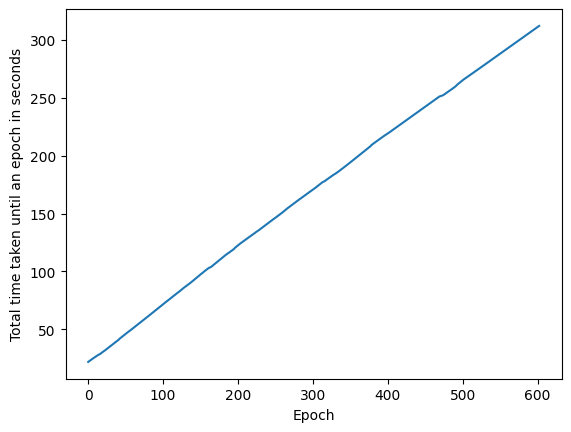

In [15]:
small_multi_mlp.fit(small_train_dataset, epochs=1000,
                                          validation_data=small_val_dataset,
                                          callbacks=[ckpt_small_multi, logs_small_multi,
                                                     earlystopping_100])

### III.1.d Reset GPU memory

In [6]:
device = cuda.get_current_device()
device.reset()

### III.1.e Define single-output MLPs

In [ ]:
small_inde_mlps = []

for i in range(48):
    small_inde_mlps.append(get_simple_mutli_regressor_mlp(input_shape=(10000,),
                                                              hidden_units=[512],
                                                              num_outputs=1))

small_inde_mlps[0].summary()

### III.1.f Compile single-output MLPs

In [ ]:
for i in range(48):
    small_inde_mlp = small_inde_mlps[i]
    small_inde_mlp.compile(optimizer="Adam", loss="mse",
                           metrics=[tf.keras.metrics.RootMeanSquaredError()])

### III.1.g Fit single-output MLPs

In [ ]:
for i in range(48):
    small_inde_mlp = small_inde_mlps[i]
    small_inde_mlp.fit(small_train_datasets_single[i], epochs=1000,
                       validation_data=small_val_datasets_single[i],
                       callbacks=[ckpt_small_single[i], logs_small_single[i],
                                                                    earlystopping_100])

### III.1.h Reset GPU memory

In [3]:
device = cuda.get_current_device()
device.reset()

## III.2 Small correlated dataset

### III.2.a Define mutli-output MLP

In [14]:
small_corr_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[512], num_outputs=48)
small_corr_multi_mlp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 512)               5120512   
_________________________________________________________________
dense_1 (Dense)              (None, 48)                24624     
Total params: 5,145,136
Trainable params: 5,145,136
Non-trainable params: 0
_________________________________________________________________


### III.2.b Compile mutli-output MLP

In [ ]:
small_corr_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])


### III.2.c Fit mutli-output MLP

In [ ]:
small_corr_multi_mlp.fit(small_corr_train_dataset, epochs=1000,
                                          validation_data=small_corr_val_dataset,
                                          callbacks=[ckpt_small_corr_multi, logs_small_corr_multi,
                                                     earlystopping_100])

### III.2.d Reset GPU memory

In [ ]:
device = cuda.get_current_device()
device.reset()

### III.2.e Define single-output MLPs

In [14]:
small_corr_inde_mlps = []

for i in range(48):
    small_corr_inde_mlps.append(get_simple_mutli_regressor_mlp(input_shape=(10000,),
                                                              hidden_units=[512],
                                                              num_outputs=1))

small_inde_mlps[0].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 512)               5120512   
_________________________________________________________________
dense_1 (Dense)              (None, 48)                24624     
Total params: 5,145,136
Trainable params: 5,145,136
Non-trainable params: 0
_________________________________________________________________


### III.2.f Compile single-output MLPs

In [ ]:
for i in range(48):
    small_corr_inde_mlp = small_corr_inde_mlps[i]
    small_corr_inde_mlp.compile(optimizer="Adam", loss="mse",
                           metrics=[tf.keras.metrics.RootMeanSquaredError()])

### III.2.g Fit single-output MLPs

In [ ]:
for i in range(48):
    small_corr_inde_mlp = small_corr_inde_mlps[i]
    small_corr_inde_mlp.fit(small_corr_train_datasets_single[i], epochs=1000,
                       validation_data=small_corr_val_datasets_single[i],
                       callbacks=[ckpt_small_corr_single[i], logs_small_corr_single[i],
                                                                    earlystopping_100])

### III.2.h Reset GPU memory

In [ ]:
device = cuda.get_current_device()
device.reset()

## III.3 Large independent dataset

### III.3.a Define mutli-output MLP

In [14]:
large_multi_mlp = get_regularised_bn_dropout_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[4096, 512],
                                                                 l2_reg_coeff=0,
                                                                 dropout_rate=0.2,
                                                                 num_outputs=48)
large_multi_mlp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 512)               5120512   
_________________________________________________________________
dense_1 (Dense)              (None, 48)                24624     
Total params: 5,145,136
Trainable params: 5,145,136
Non-trainable params: 0
_________________________________________________________________


### III.3.b Compile mutli-output MLP

In [ ]:
large_multi_mlp.compile(optimizer=tf.keras.optimizers.Adam(0.0008), loss="mse",
                        metrics=[tf.keras.metrics.RootMeanSquaredError()])

### III.3.c Fit mutli-output MLP

In [ ]:
large_multi_mlp.fit(large_train_dataset, epochs=1000,
                                          validation_data=large_val_dataset,
                                          callbacks=[ckpt_large_multi, logs_large_multi,
                                                     earlystopping_100])

### III.3.d Reset GPU memory

In [ ]:
device = cuda.get_current_device()
device.reset()

### III.3.e Define single-output MLPs

In [14]:
large_inde_mlps = []

for i in range(48):
    large_inde_mlps.append(get_regularised_bn_dropout_mutli_regressor_mlp(input_shape=(10000,),
                                                                          hidden_units=[4096, 512],
                                                                          l2_reg_coeff=0,
                                                                          dropout_rate=0.2,
                                                                          num_outputs=1))

large_inde_mlps[0].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 512)               5120512   
_________________________________________________________________
dense_1 (Dense)              (None, 48)                24624     
Total params: 5,145,136
Trainable params: 5,145,136
Non-trainable params: 0
_________________________________________________________________


### III.3.f Compile single-output MLPs

In [ ]:
for i in range(48):
    large_inde_mlp = large_inde_mlps[i]
    large_inde_mlp.compile(optimizer=tf.keras.optimizers.Adam(0.0008), loss="mse",
                        metrics=[tf.keras.metrics.RootMeanSquaredError()])

### III.3.g Fit single-output MLPs

In [ ]:
for i in range(48):
    large_inde_mlp = large_inde_mlps[i]
    large_inde_mlp.fit(large_train_datasets_single[i], epochs=1000,
                       validation_data=large_val_datasets_single[i],
                       callbacks=[ckpt_large_single[i], logs_large_single[i], earlystopping_100])

### III.3.h Reset GPU memory

In [ ]:
device = cuda.get_current_device()
device.reset()

## III.4 Large correlated dataset

### III.4.a Define mutli-output MLP

In [14]:
large_corr_multi_mlp = get_regularised_bn_dropout_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[4096, 512],
                                                                 l2_reg_coeff=0,
                                                                 dropout_rate=0.2,
                                                                 num_outputs=48)
large_corr_multi_mlp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 512)               5120512   
_________________________________________________________________
dense_1 (Dense)              (None, 48)                24624     
Total params: 5,145,136
Trainable params: 5,145,136
Non-trainable params: 0
_________________________________________________________________


### III.4.b Compile mutli-output MLP

In [ ]:
large_corr_multi_mlp.compile(optimizer=tf.keras.optimizers.Adam(0.0008), loss="mse",
                        metrics=[tf.keras.metrics.RootMeanSquaredError()])

### III.4.c Fit mutli-output MLP

In [ ]:
large_corr_multi_mlp.fit(large_corr_train_dataset, epochs=1000,
                                          validation_data=large_corr_val_dataset,
                                          callbacks=[ckpt_large_corr_multi, logs_large_corr_multi,
                                                     earlystopping_100])

### III.4.d Reset GPU memory

In [ ]:
device = cuda.get_current_device()
device.reset()

### III.4.d Define single-output MLPs

In [14]:
large_corr_inde_mlps = []

for i in range(48):
    large_corr_inde_mlps.append(get_regularised_bn_dropout_mutli_regressor_mlp(input_shape=(10000,),
                                                                          hidden_units=[4096, 512],
                                                                          l2_reg_coeff=0,
                                                                          dropout_rate=0.2,
                                                                          num_outputs=1))

large_corr_inde_mlps[0].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 512)               5120512   
_________________________________________________________________
dense_1 (Dense)              (None, 48)                24624     
Total params: 5,145,136
Trainable params: 5,145,136
Non-trainable params: 0
_________________________________________________________________


### III.4.e Compile single-output MLPs

In [ ]:
for i in range(48):
    large_corr_inde_mlp = large_corr_inde_mlps[i]
    large_corr_inde_mlp.compile(optimizer=tf.keras.optimizers.Adam(0.0008), loss="mse",
                        metrics=[tf.keras.metrics.RootMeanSquaredError()])

### III.4.f Fit single-output MLPs

In [ ]:
for i in range(48):
    large_corr_inde_mlp = large_corr_inde_mlps[i]
    large_corr_inde_mlp.fit(large_corr_train_datasets_single[i], epochs=1000,
                       validation_data=large_corr_val_datasets_single[i],
                       callbacks=[ckpt_large_corr_single[i], logs_large_corr_single[i], earlystopping_100])

### III.4.h Reset GPU memory

In [ ]:
device = cuda.get_current_device()
device.reset()

## III.5 Exrtra small independent dataset

### III.5.a Mutli output MLP

In [39]:
xsmall_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[256], num_outputs=48)
xsmall_multi_mlp.summary()

Model: "model_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_147 (InputLayer)       [(None, 10000)]           0         
_________________________________________________________________
dense_336 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_337 (Dense)            (None, 48)                12336     
Total params: 2,572,592
Trainable params: 2,572,592
Non-trainable params: 0
_________________________________________________________________


### III.5.b Compile mutli-output MLP

In [ ]:
xsmall_multi_mlp.compile(optimizer=tf.keras.optimizers.Adam(0.002), loss="mse",
                         metrics=[tf.keras.metrics.RootMeanSquaredError()])


### III.5.c Fit mutli-output MLP

In [ ]:
xsmall_multi_mlp.fit(xsmall_train_dataset, epochs=1000,
                                          validation_data=xsmall_val_dataset,
                                          callbacks=[ckpt_xsmall_multi, logs_xsmall_multi,
                                                     earlystopping_100])

### III.5.d Reset GPU memory

In [ ]:
device = cuda.get_current_device()
device.reset()

### III.5.e Define single-output MLPs

In [14]:
xsmall_inde_mlps = []

for i in range(48):
    xsmall_inde_mlps.append(get_simple_mutli_regressor_mlp(input_shape=(10000,),
                                                              hidden_units=[256],
                                                              num_outputs=1))

small_inde_mlps[0].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 512)               5120512   
_________________________________________________________________
dense_1 (Dense)              (None, 48)                24624     
Total params: 5,145,136
Trainable params: 5,145,136
Non-trainable params: 0
_________________________________________________________________


### III.5.f Compile single-output MLPs

In [ ]:
for i in range(48):
    xsmall_inde_mlp = xsmall_inde_mlps[i]
    xsmall_inde_mlp.compile(optimizer=tf.keras.optimizers.Adam(0.002), loss="mse",
                           metrics=[tf.keras.metrics.RootMeanSquaredError()])

### III.5.g Fit single-output MLPs

In [ ]:
for i in range(48):
    xsmall_inde_mlp = xsmall_inde_mlps[i]
    xsmall_inde_mlp.fit(xsmall_train_datasets_single[i], epochs=1000,
                       validation_data=xsmall_val_datasets_single[i],
                       callbacks=[ckpt_xsmall_single[i], logs_xsmall_single[i], earlystopping_100])

### III.5.h Reset GPU memory

In [ ]:
device = cuda.get_current_device()
device.reset()

## III.6 Extra small correlated dataset

### III.6.a Mutli output MLP

In [49]:
xsmall_corr_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[256], num_outputs=48)
xsmall_corr_multi_mlp.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[10000,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

### III.6.b Compile mutli-output MLP

In [ ]:
xsmall_corr_multi_mlp.compile(optimizer=tf.keras.optimizers.Adam(0.0025), loss="mse",
                         metrics=[tf.keras.metrics.RootMeanSquaredError()])


### III.6.c Fit mutli-output MLP

In [ ]:
xsmall_corr_multi_mlp.fit(xsmall_corr_train_dataset, epochs=1000,
                                          validation_data=xsmall_corr_val_dataset,
                                          callbacks=[ckpt_xsmall_corr_multi, logs_xsmall_corr_multi,
                                                     earlystopping_100])

### III.6.d Reset GPU memory

In [ ]:
device = cuda.get_current_device()
device.reset()

### III.6.e Define single-output MLPs

In [14]:
xsmall_corr_inde_mlps = []

for i in range(48):
    xsmall_corr_inde_mlps.append(get_simple_mutli_regressor_mlp(input_shape=(10000,),
                                                              hidden_units=[256],
                                                              num_outputs=1))

xsmall_corr_inde_mlps[0].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 512)               5120512   
_________________________________________________________________
dense_1 (Dense)              (None, 48)                24624     
Total params: 5,145,136
Trainable params: 5,145,136
Non-trainable params: 0
_________________________________________________________________


### III.6.f Compile single-output MLPs

In [ ]:
for i in range(48):
    xsmall_corr_inde_mlp = xsmall_corr_inde_mlps[i]
    xsmall_corr_inde_mlp.compile(optimizer=tf.keras.optimizers.Adam(0.0025), loss="mse",
                           metrics=[tf.keras.metrics.RootMeanSquaredError()])

### III.6.g Fit single-output MLPs

In [ ]:
for i in range(48):
    xsmall_corr_inde_mlp = xsmall_corr_inde_mlps[i]
    xsmall_corr_inde_mlp.fit(xsmall_corr_train_datasets_single[i], epochs=1000,
                       validation_data=xsmall_corr_val_datasets_single[i],
                       callbacks=[ckpt_xsmall_corr_single[i], logs_xsmall_corr_single[i], earlystopping_100])

### III.6.h Reset GPU memory

In [ ]:
device = cuda.get_current_device()
device.reset()